# Explore the mosaic

This section contains examples to work with the entire mosaic of Sentinel 2 [we have mirrored](GHS-composite-S2_mirror).

In [104]:
import rioxarray, xarray
import geopandas, pandas
import contextily
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import box
from numpy import percentile

### Extract window

In this example we will clip a section of the entire mosaic, transform it into true color, and plot it.

First connect to the `.vrt`:

In [14]:
r = rioxarray.open_rasterio(local_dir+"GHS-composite-S2.vrt")
r

<xarray.DataArray (band: 4, y: 182437, x: 121865)>
[88930740020 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2 3 4
  * y            (y) float64 1.612e+06 1.612e+06 ... -2.136e+05 -2.136e+05
  * x            (x) float64 -2.228e+05 -2.228e+05 ... 9.968e+05 9.968e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

Now get a box for Liverpool:

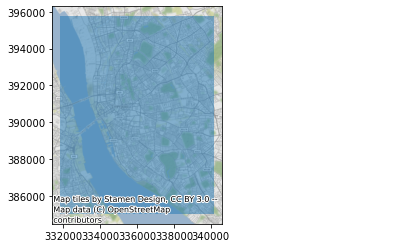

In [126]:
bb = box(331825, 385032, 340167, 395756)
ax = geopandas.GeoSeries([bb], crs="EPSG:27700").plot(alpha=0.5)
contextily.add_basemap(ax, crs="EPSG:27700");

In [130]:
%time sub = r.sel(band=[1, 2, 3]).rio.clip_box(*bb.bounds)
sub

CPU times: user 74.2 ms, sys: 0 ns, total: 74.2 ms
Wall time: 71.9 ms


<xarray.DataArray (band: 3, y: 1072, x: 834)>
[2682144 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2 3
  * y            (y) float64 3.958e+05 3.957e+05 3.957e+05 ... 3.85e+05 3.85e+05
  * x            (x) float64 3.318e+05 3.318e+05 ... 3.402e+05 3.402e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref
    _FillValue:    0

With this, we can rescale it using `scikit-learn` preprocessing tools and visualise it:

CPU times: user 223 ms, sys: 0 ns, total: 223 ms
Wall time: 220 ms


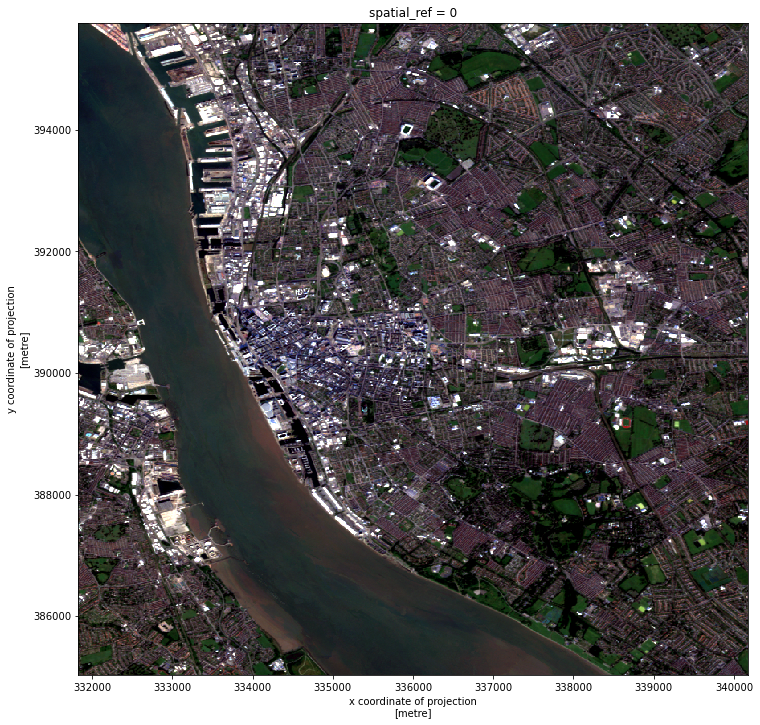

In [129]:
%%time
def minmax(a, 
           bottom=0, 
           top=255, 
           min_cut=2.5, 
           max_cut=98.5
          ):
    vals = a.to_series().values
    min_bin = percentile(vals, min_cut)
    max_bin = percentile(vals, max_cut)
    a = xarray.where(a > max_bin, max_bin, a)
    a = xarray.where(a < min_bin, min_bin, a)
    a_std = (a - a.min()) / (a.max() - a.min())
    a_scaled = a_std * (top - bottom) + bottom
    return a_scaled.astype(int)

sub.groupby("band")\
   .map(minmax)\
   .plot.imshow(figsize=(12, 12));

---

Alternative, `sklearn`-based (but slower because of reshaping required:

In [101]:
%%time
def chopper(s, cutoff=0.98):
    scut = pandas.qcut(s, [0, cutoff, 1])
    return None
scaler = MinMaxScaler(feature_range=(0, 255))
ssub = sub.to_series()\
          .unstack(level="band")
scaled = scaler.fit_transform(ssub)
scaled = pandas.DataFrame(scaled.astype(int), 
                          columns=pandas.Index([1, 2, 3], 
                                               name="band"
                                              ),
                          index=ssub.index
                         )
scaled = xarray.DataArray.from_series(scaled.stack())

CPU times: user 5.48 s, sys: 0 ns, total: 5.48 s
Wall time: 5.48 s
